## Pruebas

In [1]:
%pylab inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [2]:
#products = pd.read_csv('products_clean.csv')
#sales = pd.read_csv('sales_clean.csv')
#stock = pd.read_csv('stock_clean.csv')
sales_prod = pd.read_csv('sp_clean.csv')
#stock_prod = pd.read_csv('stp_clean.csv')
#groupby_sales = pd.read_csv('gb_sales_clean.csv')
#subcategories_list = pd.read_csv('subc_list_clean.csv')
#materials_list = pd.read_csv('mat_list_clean.csv')

## MODELOS ML

In [3]:
import time

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns


from datetime import datetime
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

In [4]:
pd.set_option('display.max_columns', None)
sales_prod.head(1)

,Unnamed: 0,ID,NRO_DOCUMENTO,FECHA,CODIGO_TIENDA,TIENDA,PROD_REF,CANTIDAD,PRECIO,SUBTOTAL,DESCUENTO(%),TOTAL,ANIO,MES,DIA,ITEM,REF,DESCRIPCION,CATEGORIA,SUBCATEGORIA,VIGENCIA,ORIGEN,ESTILO,MATERIAL,ACABADO,PUESTOS,COLOR,ANCHO,ALTO,FONDO,DESC_LARGA,SUBCATEGORIA_POS,COLOR_POS,MATERIAL_POS
0,0,11:FSV-00001071:XZ0862:00005:,FSV-00001071,2019-01-17,11,ADMINISTRACION,XZ0862:00005:,1,188922.0,188922,0.599999,75569,2019,1,3,6084,XZ0862:00005:,MESA AUX LAUREL,SALAS Y SOFAS,MESAS AUXILIARES,LINEA,IMPORTADO,CONTEMPORÁNEO,MADERA+VIDRIO,MATE,NaN,NEGRO,40.0,45.0,40.0,MESA AUXILIAR LAUREL 39X40X50 CRISTAL NG,OTROS,NEGRO,OTRO


In [5]:
sales_prod['AREA']=sales_prod['ANCHO']*sales_prod['FONDO']

In [6]:
sales_prod['PUESTOS'].fillna(0,inplace=True)

In [7]:

columns_HD = ['REF','TIENDA', 'PRECIO', 'SUBTOTAL','DESCUENTO(%)','TOTAL','CANTIDAD','ANIO','MES','CATEGORIA','SUBCATEGORIA','VIGENCIA','ORIGEN','ESTILO','MATERIAL','ACABADO','COLOR','ALTO','AREA','PUESTOS']
columns_LD= ['REF','TIENDA', 'PRECIO', 'SUBTOTAL','DESCUENTO(%)','TOTAL','CANTIDAD','ANIO','MES','CATEGORIA','SUBCATEGORIA_POS','VIGENCIA','ORIGEN','ESTILO','MATERIAL_POS','ACABADO','COLOR_POS','ALTO','AREA','PUESTOS']

In [8]:
sales_prod_HD=sales_prod[columns_HD]
sales_prod_LD=sales_prod[columns_LD]

<AxesSubplot:>

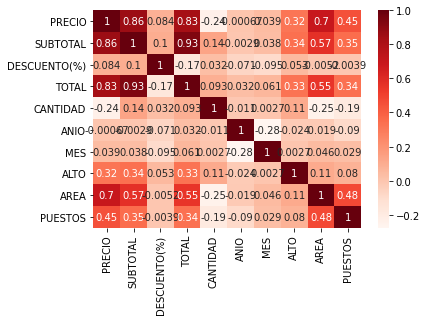

In [9]:
sns.heatmap(sales_prod_HD.corr(),cmap='Reds',annot=True)

sacar precio afuera?

**Solo por producto**

In [161]:
sales_ref_month=sales_prod_LD.groupby(['ANIO','MES','REF','TIENDA']).agg({'PRECIO':'mean','SUBTOTAL':'sum','DESCUENTO(%)':'mean','TOTAL':'sum','CANTIDAD':'sum','ALTO':'first','AREA':'first','PUESTOS':'first','COLOR_POS':'first','CATEGORIA':'first','SUBCATEGORIA_POS':'first','VIGENCIA':'first','ORIGEN':'first','ESTILO':'first','MATERIAL_POS':'first','ACABADO':'first'}).reset_index().sort_values(by=['ANIO','MES'])

<AxesSubplot:>

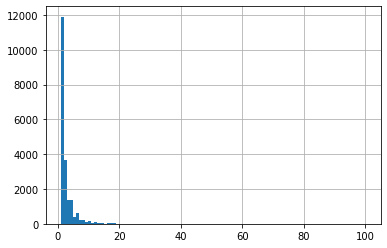

In [226]:
sales_ref_month.CANTIDAD.hist(bins=100)

In [229]:
sales_ref_month.CANTIDAD.quantile(0.99)

16.0

In [11]:
covid=sales_ref_month[['ANIO','MES']].drop_duplicates().reset_index(drop=True)
aux2=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,1,1,1,2,2,1,1,2,2,1,1,1]

In [12]:
covid['Factor covid']=aux2


In [13]:
sales_ref_month=sales_ref_month.merge(covid,on=['ANIO','MES'])

<AxesSubplot:>

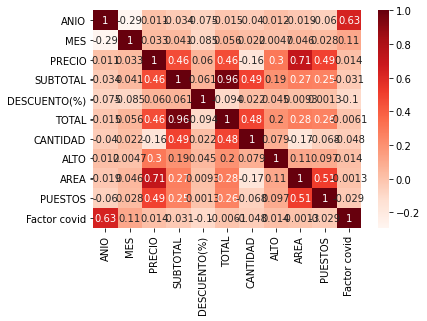

In [14]:
sns.heatmap(sales_ref_month.corr(),cmap='Reds',annot=True)

In [68]:
def remove_outlier_IQR(df):
    Q1=df.quantile(0.25)
    Q3=df.quantile(0.75)
    IQR=Q3-Q1
    df_final=df[~((df<(Q1-1.5*IQR)) | (df>(Q3+1.5*IQR)))]
    return df_final

In [69]:
sales_ref_month2=sales_ref_month.loc[remove_outlier_IQR(sales_ref_month['CANTIDAD']).index].reset_index(drop=True)

In [70]:
num_var=['AREA','ALTO','DESCUENTO(%)','PRECIO','CANTIDAD',]
cat_var=['MES','Factor covid','PUESTOS','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','VIGENCIA','ORIGEN','ESTILO','MATERIAL_POS','ACABADO','TIENDA']

In [71]:
y=sales_ref_month2['CANTIDAD']

In [72]:
X_num=sales_ref_month2[num_var[:-1]].astype('float')
X_cat=sales_ref_month2[cat_var].astype('category')

In [73]:
X_cat_dummies=pd.get_dummies(X_cat)

In [74]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [75]:
scaler=MinMaxScaler()
X_num_norm= scaler.fit_transform(X_num)


In [76]:
X=np.append(X_num_norm,X_cat_dummies,axis=1)

In [77]:
#split data till march 2021
index=sales_ref_month2[(sales_ref_month2.ANIO==2021)& (sales_ref_month2.MES==3)].index[0]
X_train=X[:index-1]
y_train=y[:index-1]
X_test=X[index:]
y_test=y[index:]


In [78]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse

In [79]:
mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               CANTIDAD   R-squared:                       0.078
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     16.25
Date:                Sat, 28 Aug 2021   Prob (F-statistic):          1.16e-214
Time:                        16:50:03   Log-Likelihood:                -14509.
No. Observations:               15727   AIC:                         2.918e+04
Df Residuals:                   15644   BIC:                         2.982e+04
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.406e+10   1.15e+12     -0.030      0.976   -2.29e+12    2.22e+12
x1            -0.0171      0.080     -0.213      0.831      -0.175       0.140
x2             0.0977      0.065      1.498      0.134      -0.030       0.225
x3             0.1649      0.032      5.177      0.000       0.102       0.227
x4            -0.2561      0.077     -3.339      0.001      -0.406      -0.106
x5          1.144e+09   3.87e+10      0.030      0.976   -7.47e+10     7.7e+10
x6          1.144e+09   3.87e+10      0.030      0.976   -7.47e+10     7.7e+10
x7          1.144e+09   3.87e+10      0.030      0.976   -7.47e+10     7.7e+10
x8          1.144e+09   3.87e+10      0.030      0.976   -7.47e+10     7.7e+10
x9          1.144e+09   3.87e+10      0.030      0.976   -7.47e+10     7.7e+10
x10         1.144e+09   3.87e+10      0.030      0.976   -7.47e+10     7.7e+10
x11         1.144e+09   3.87e+10      0.030      0.976   -7.47e+10     7.7e+10
x12         1.144e+09   3.87e+10      0.030      0.976   -7.47e+10     7.7e+10
x13         1.144e+09   3.87e+10      0.030      0.976   -7.47e+10     7.7e+10
x14         1.144e+09   3.87e+10      0.030      0.976   -7.47e+10     7.7e+10
x15         1.144e+09   3.87e+10      0.030      0.976   -7.47e+10     7.7e+10
x16         1.144e+09   3.87e+10      0.030      0.976   -7.47e+10     7.7e+10
x17         9.306e+09   3.15e+11      0.030      0.976   -6.08e+11    6.27e+11
x18         9.306e+09   3.15e+11      0.030      0.976   -6.08e+11    6.27e+11
x19         9.306e+09   3.15e+11      0.030      0.976   -6.08e+11    6.27e+11
x20         9.306e+09   3.15e+11      0.030      0.976   -6.08e+11    6.27e+11
x21        -4.522e+09   1.53e+11     -0.030      0.976   -3.04e+11    2.95e+11
x22        -4.522e+09   1.53e+11     -0.030      0.976   -3.04e+11    2.95e+11
x23        -4.522e+09   1.53e+11     -0.030      0.976   -3.04e+11    2.95e+11
x24        -4.522e+09   1.53e+11     -0.030      0.976   -3.04e+11    2.95e+11
x25        -4.522e+09   1.53e+11     -0.030      0.976   -3.04e+11    2.95e+11
x26        -4.522e+09   1.53e+11     -0.030      0.976   -3.04e+11    2.95e+11
x27        -4.522e+09   1.53e+11     -0.030      0.976   -3.04e+11    2.95e+11
x28        -2.911e+09   9.85e+10     -0.030      0.976   -1.96e+11     1.9e+11
x29        -2.911e+09   9.85e+10     -0.030      0.976   -1.96e+11     1.9e+11
x30        -2.911e+09   9.85e+10     -0.030      0.976   -1.96e+11     1.9e+11
x31        -2.911e+09   9.85e+10     -0.030      0.976   -1.96e+11     1.9e+11
x32        -2.911e+09   9.85e+10     -0.030      0.976   -1.96e+11     1.9e+11
x33        -2.911e+09   9.85e+10     -0.030      0.976   -1.96e+11     1.9e+11
x34        -2.911e+09   9.85e+10     -0.030      0.976   -1.96e+11     1.9e+11
x35        -2.911e+09   9.85e+10     -0.030      0.976   -1.96e+11     1.9e+11
x3

In [80]:
y_predicted=res.predict(sm.add_constant(X_test,has_constant='add'))
mse(y_test,y_predicted)

0.37200134833896026

(0.0, 600.0)

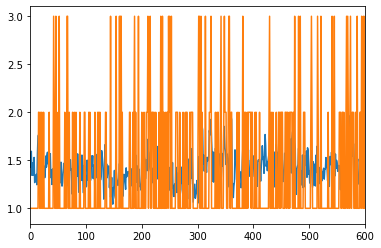

In [81]:
plt.plot(range(len(y_predicted)),y_predicted)
plt.plot(range(len(y_predicted)),y_test)
plt.xlim(0,600)


In [33]:
from sklearn.ensemble import GradientBoostingRegressor

In [82]:
br=GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 300})

In [83]:
br.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=300)

In [84]:
from sklearn.metrics import mean_squared_error as mse
mse(br.predict(X_test),y_test)

0.36391785230939294

In [ ]:
mse

In [85]:
t=sales_ref_month2[index:]
t['predicted']=br.predict(X_test)
t2=t.groupby(['REF','MES','ANIO']).agg({'predicted':'sum','CANTIDAD':'sum'}).reset_index()
t2

,REF,MES,ANIO,predicted,CANTIDAD
0,BR0002:00193:,4,2021,2.556949,3
1,BR0003:00194:,4,2021,2.714782,4
2,BR0005:00193:,3,2021,2.880296,2
3,BR0005:00193:,4,2021,1.241661,1
4,BR0007:00195:,3,2021,2.898424,2
...,...,...,...,...,...
637,XZ0934:00137:,3,2021,1.420233,1
638,XZ0972:00024:,3,2021,1.565879,1
639,XZ0973:00046:,3,2021,1.607130,1
640,XZ0993:00100:,3,2021,1.378982,1


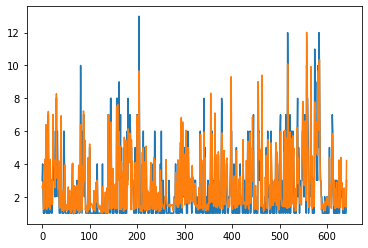

In [86]:
plt.plot(t2.CANTIDAD)
plt.plot(t2.predicted)

(0.0, 100.0)

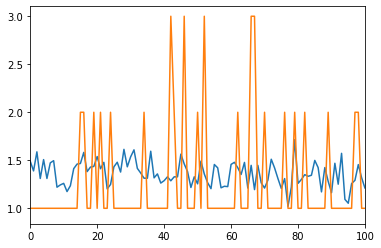

In [87]:
plt.plot(range(len(y_predicted)),br.predict(X_test))
plt.plot(range(len(y_predicted)),y_test)
plt.xlim(0,100)

In [38]:
from sklearn.metrics import r2_score as r2
r2(br.predict(X_test),y_test)

-9.955809213387369

In [34]:
list(zip(X_num.columns.append(X_cat_dummies.columns),br.feature_importances_))

[('AREA', 0.05574620585125613),
 ('ALTO', 0.033779026768740984),
 ('DESCUENTO(%)', 0.4777923230414482),
 ('PRECIO', 0.10944696549753398),
 ('MES_1', 0.014640925988445725),
 ('MES_2', 0.009049249125743269),
 ('MES_3', 0.001579097228123056),
 ('MES_4', 0.0023221175603797143),
 ('MES_5', 0.0029939640450905632),
 ('MES_6', 0.0008520993082224576),
 ('MES_7', 0.003004516549775797),
 ('MES_8', 0.0012079650601133324),
 ('MES_9', 0.000578760289888369),
 ('MES_10', 0.00406103909617418),
 ('MES_11', 0.0005238774607143171),
 ('MES_12', 0.00364194271066402),
 ('Factor covid_0', 0.007565933391367926),
 ('Factor covid_1', 0.0006147372927978665),
 ('Factor covid_2', 0.001118058710040306),
 ('Factor covid_3', 0.002616218010534017),
 ('PUESTOS_0.0', 0.006074706040840327),
 ('PUESTOS_1.0', 0.0005351144107219504),
 ('PUESTOS_2.0', 0.0),
 ('PUESTOS_3.0', 0.002214164031886986),
 ('PUESTOS_4.0', 0.0028969556341387876),
 ('PUESTOS_6.0', 0.0011810937295948143),
 ('PUESTOS_7.0', 0.0),
 ('COLOR_POS_AMARILLO', 0.

In [88]:
param_dist = {'n_estimators':[30, 40, 100, 200, 300],'learning_rate':[0.01, 0.05, 0.1, 0.3, 0.4, 1], 'max_depth': [2,4,6,8,10]}

In [89]:
grid_clf_br = GridSearchCV(GradientBoostingRegressor(), param_grid = param_dist,cv=3,n_jobs=4,scoring='neg_mean_squared_error')
grid_clf_br.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.4, 1],
                         'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [30, 40, 100, 200, 300]},
             scoring='neg_mean_squared_error')

In [90]:
grid_clf_br.best_score_

-0.3676259697893915

In [91]:
grid_clf_br.best_params_

{'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}

In [97]:
import joblib
joblib.dump(grid_clf_br,'model_sin_out_tiendas.pkl')

['model_sin_out_tiendas.pkl']

In [101]:
loaded_model = joblib.load('model_sin_out_tiendas.pkl')
result = mse(loaded_model.predict(X_test), y_test)
result

0.36091235226845697

In [92]:
best={'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 200}

In [93]:
mse(grid_clf_br.predict(X_test),y_test)

0.36091235226845697

In [102]:
mse(grid_clf_br.predict(X_train),y_train)

0.3345549220548181

In [43]:
y_predicted2=grid_clf_br.predict(X_test)

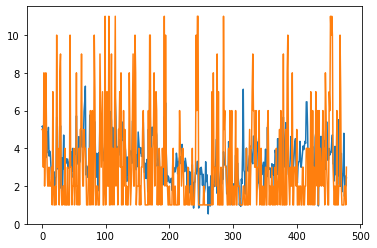

In [44]:
plt.figure()
plt.plot(range(len(y_predicted2)),(y_predicted2))
plt.plot(range(len(y_predicted2)),(y_test))

In [213]:
sales_train=sales_ref_month2[:index-1]
sales_test=sales_ref_month2[index:]
sales_train['predicted']=grid_clf_br.predict(X_train)
sales_test['predicted']=grid_clf_br.predict(X_test)
sales_test['fecha']= pd.to_datetime(sales_test['ANIO'].astype(str)+'/'+sales_test['MES'].astype(str))#,format="%Y/%M")
sales_train['fecha']= pd.to_datetime(sales_train['ANIO'].astype(str)+'/'+sales_train['MES'].astype(str))#,format="%Y/%M")

joint=pd.concat([sales_train,sales_test],axis=0)



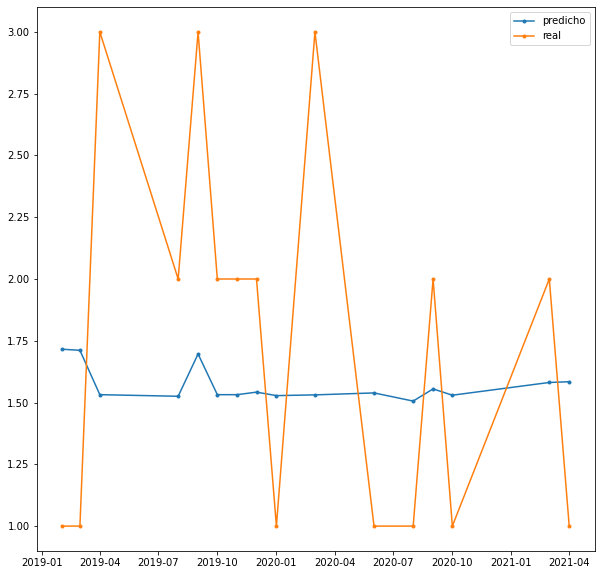

In [230]:
def plot_by_ref_tienda(ref,tienda):
    aux=joint.query('REF==@ref & TIENDA==@tienda')
    plt.figure(figsize=(10,10))
    plt.plot(aux['fecha'],aux['predicted'],label='predicho',marker='.')
    plt.plot(aux['fecha'],aux['CANTIDAD'],label='real',marker='.')
    plt.legend()
plot_by_ref_tienda('D00935:00048:00048','PUNTO DE VENTA AV 68')



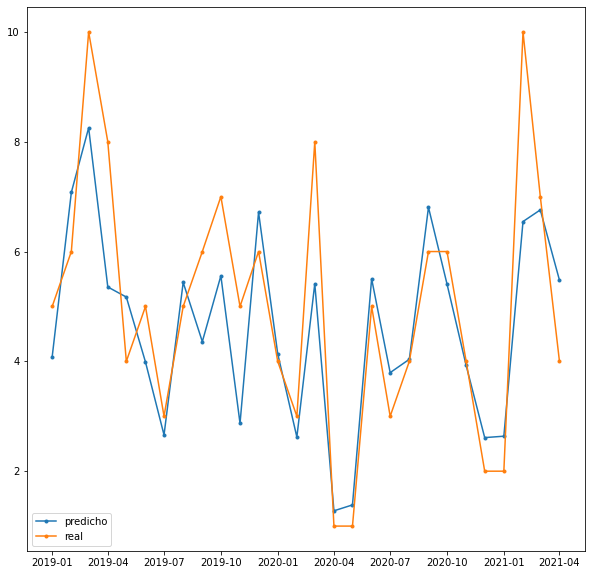

In [231]:
def plot_by_ref(ref):
    aux0=joint.groupby(['REF','ANIO','MES','fecha']).agg({'CANTIDAD':'sum','predicted':'sum'}).reset_index()
    aux=aux0.query('REF==@ref')
    plt.figure(figsize=(10,10))
    plt.plot(aux['fecha'],aux['predicted'],label='predicho',marker='.')
    plt.plot(aux['fecha'],aux['CANTIDAD'],label='real',marker='.')
    plt.legend()
plot_by_ref('D00935:00048:00048')

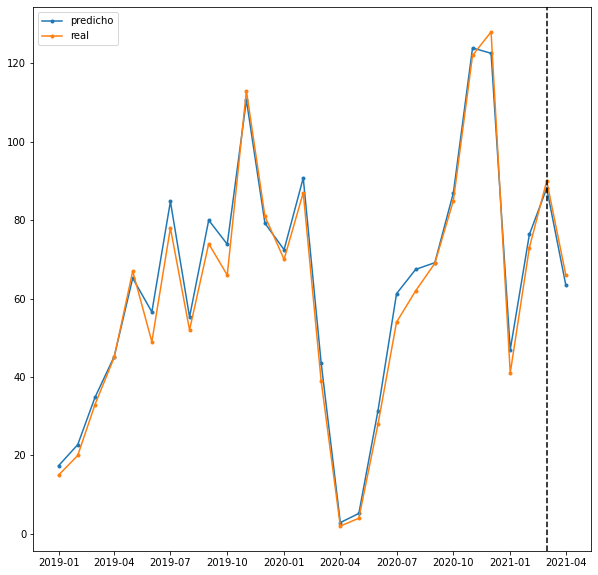

In [225]:
def plot_by_cat(subcat):
    aux0=joint.groupby(['SUBCATEGORIA_POS','ANIO','MES','fecha']).agg({'CANTIDAD':'sum','predicted':'sum'}).reset_index()
    aux=aux0.query('SUBCATEGORIA_POS==@subcat')
    #print(aux)
    plt.figure(figsize=(10,10))
    plt.plot(aux['fecha'],aux['predicted'],label='predicho',marker='.')
    plt.plot(aux['fecha'],aux['CANTIDAD'],label='real',marker='.')
    plt.axvline(x=pd.to_datetime('2021-03-01'),color='black',linestyle='--')
    plt.legend()
plot_by_cat('SOFA 2P')


In [181]:
l2.fecha

566     2019-01-01 00:02:00
1062    2019-01-01 00:03:00
1794    2019-01-01 00:04:00
4310    2019-01-01 00:08:00
4939    2019-01-01 00:09:00
5585    2019-01-01 00:10:00
6304    2019-01-01 00:11:00
7101    2019-01-01 00:12:00
7802    2020-01-01 00:01:00
9293    2020-01-01 00:03:00
9879    2020-01-01 00:06:00
10950   2020-01-01 00:08:00
11478   2020-01-01 00:09:00
12216   2020-01-01 00:10:00
Name: fecha, dtype: datetime64[ns]

In [172]:
l2=sales_train.query('REF=="D00935:00048:00048"& TIENDA=="PUNTO DE VENTA AV 68"')
l2.CANTIDAD

566      1
1062     1
1794     3
4310     2
4939     3
5585     2
6304     2
7101     2
7802     1
9293     3
9879     1
10950    1
11478    2
12216    1
Name: CANTIDAD, dtype: int64

In [207]:
sales_test['SUBCATEGORIA_POS'].value_counts()

OTROS                 458
SOFA 2P               115
SET 4P                101
SOFA 3P               100
SOFA CAMA ABATIBLE     78
MESAS DE CENTRO        68
SILLAS AUXILIARES      56
RECLINABLES            52
POLTRONAS              49
PUFF                   48
RECLINABLES 1P         41
SET 6P                 30
SILLAS DE COMEDOR      29
MESAS DE 4P            26
Name: SUBCATEGORIA_POS, dtype: int64

In [160]:
l2.CANTIDAD.value_counts()

1    53
2    26
3     8
Name: CANTIDAD, dtype: int64

In [141]:
sales_train.groupby(['REF','TIENDA','FECHA'])

,ANIO,MES,REF,TIENDA,PRECIO,SUBTOTAL,DESCUENTO(%),TOTAL,CANTIDAD,ALTO,AREA,PUESTOS,COLOR_POS,CATEGORIA,SUBCATEGORIA_POS,VIGENCIA,ORIGEN,ESTILO,MATERIAL_POS,ACABADO,Factor covid,predicted,fecha
15728,2021,3,BR0005:00193:,PUNTO DE VENTA AV 68,505512.0,505512,0.391049,307832,1,77.0,7800.0,0.0,OTRO,ESTUDIO,OTROS,NOVEDAD,IMPORTADO,CONTEMPORÁNEO,MADERA LAMINADA,MATE,1,2.0,2021-01-01 00:03:00
15729,2021,3,BR0005:00193:,PUNTO DE VENTA CALLE 134,505512.0,505512,0.391049,307832,1,77.0,7800.0,0.0,OTRO,ESTUDIO,OTROS,NOVEDAD,IMPORTADO,CONTEMPORÁNEO,MADERA LAMINADA,MATE,1,1.0,2021-01-01 00:03:00
15730,2021,3,BR0007:00195:,PUNTO DE VENTA AV 68,211616.0,211616,0.393543,128336,1,180.0,2541.0,0.0,OTRO,ESTUDIO,OTROS,NOVEDAD,IMPORTADO,CONTEMPORÁNEO,MADERA LAMINADA,MATE,1,2.0,2021-01-01 00:03:00
15731,2021,3,BR0007:00195:,PUNTO DE VENTA PLAZA CENTRAL,211616.0,211616,0.393543,128336,1,180.0,2541.0,0.0,OTRO,ESTUDIO,OTROS,NOVEDAD,IMPORTADO,CONTEMPORÁNEO,MADERA LAMINADA,MATE,1,1.0,2021-01-01 00:03:00
15732,2021,3,BR0008:00012:,PAGINA WEB FIOTTI,213405.0,213405,0.442726,118925,1,180.0,2541.0,0.0,OTRO,ESTUDIO,OTROS,NOVEDAD,IMPORTADO,CONTEMPORÁNEO,MADERA LAMINADA,MATE,1,1.0,2021-01-01 00:03:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16974,2021,4,XZ0897:00044:,PUNTO DE VENTA POBLADO,1088256.0,1088256,0.400000,652954,1,75.0,13500.0,6.0,OTRO,COMEDORES,OTROS,LINEA,IMPORTADO,MODERNO,VIDRIO,BRILLANTE,1,1.0,2021-01-01 00:04:00
16975,2021,4,XZ0914-1:00001:,PUNTO DE VENTA CALI,1984260.0,1984260,0.390870,1208672,1,75.0,8400.0,6.0,BLANCO,COMEDORES,SET 6P,LINEA,IMPORTADO,CLÁSICO,METAL + VIDRIO,MATE,1,1.0,2021-01-01 00:04:00
16976,2021,4,XZ0993:00100:,ADMINISTRACION,593462.0,593462,0.493755,300437,1,44.0,5000.0,0.0,BLANCO,SALAS Y SOFAS,MESAS DE CENTRO,DESCONTINUADO,IMPORTADO,CONTEMPORÁNEO,VIDRIO,BRILLANTE,1,1.0,2021-01-01 00:04:00
16977,2021,4,XZ0993:00100:,PUNTO DE VENTA AV 68,546678.0,546678,0.619999,207738,1,44.0,5000.0,0.0,BLANCO,SALAS Y SOFAS,MESAS DE CENTRO,DESCONTINUADO,IMPORTADO,CONTEMPORÁNEO,VIDRIO,BRILLANTE,1,1.0,2021-01-01 00:04:00


In [121]:
mse(sales_test.CANTIDAD,sales_test.predicted)

0.5019984012789768

In [ ]:
sales_test.groupby(['REF','TIENDA'])


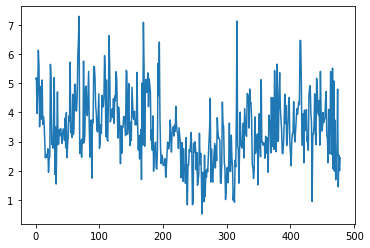

In [46]:
plt.plot(range(len(y_predicted2)),(y_predicted2))

In [ ]:
import sklearn

In [ ]:
sklearn.metrics.SCORERS.keys()

Lasso o Ridge?

In [47]:
from sklearn.linear_model import Ridge, Lasso

In [48]:
rr=Ridge(alpha=1000)
rr.fit(X_train,y_train)
mse(y_test,rr.predict(X_test))


6.1084118220422505

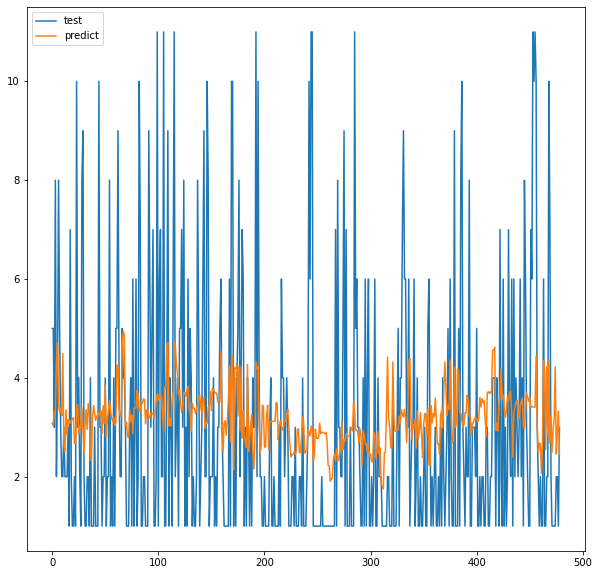

In [49]:
plt.figure(figsize=(10,10))
plt.plot(range(len(rr.predict(X_test))),y_test,label='test')
plt.plot(range(len(rr.predict(X_test))),rr.predict(X_test),label='predict')
plt.legend()

In [50]:
rr=Lasso(alpha=0.0555)
rr.fit(X_train,y_train)
mse(y_test,rr.predict(X_test))


6.203307208607622

again but scaling numerical features

In [51]:
from scipy import stats

In [177]:
X_num['DESCUENTO(%)']=X_num['DESCUENTO(%)']+0.00001
num_columns=['AREA','ALTO','DESCUENTO(%)','PRECIO'] #Descuento no se puede porque tiene 0
X_num_tran=pd.DataFrame(index=sales_ref_month2.index)
lambdas=[]
for column in num_columns:
    aux=stats.boxcox(X_num[column])
    X_num_tran["{}_TRANSFORMADO".format(column)]=aux[0]
    lambdas.append(aux[1])
    print (column,aux[1])
y_trans=stats.boxcox(y)[0]
print(y.name,stats.boxcox(y)[1])
lambda_y=stats.boxcox(y)[1]

AREA 0.11705035609036826
ALTO 0.4944249342937636
DESCUENTO(%) 0.894531584380252
PRECIO 0.1347105737570414
CANTIDAD -0.3248620938935193


In [178]:
X_num_norm2= scaler.fit_transform(X_num_tran)
y_norm2=scaler.fit_transform(y.values.reshape(-1,1))

#X=np.append(X_num_norm2,X_cat_dummies,axis=1)
X=pd.concat([X_num_tran,X_cat_dummies],axis=1)
#split data till januar 2021
index=sales_ref_month2[(sales_ref_month2.ANIO==2021)].index[0]
X_train=X[:index]
y_train=y_trans[:index]
X_test=X[index:]
y_test=y_trans[index:]

import statsmodels.api as sm

mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.132
Method:                 Least Squares   F-statistic:                     17.56
Date:                Fri, 27 Aug 2021   Prob (F-statistic):          6.76e-194
Time:                        23:00:40   Log-Likelihood:                -5991.0
No. Observations:                7647   AIC:                         1.212e+04
Df Residuals:                    7576   BIC:                         1.262e+04
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   0.4735      0.054      8.797      0.000       0.368       0.579
AREA_TRANSFORMADO                       0.0122      0.007      1.807      0.071      -0.001       0.025
ALTO_TRANSFORMADO                      -0.0017      0.004     -0.441      0.659      -0.009       0.006
DESCUENTO(%)_TRANSFORMADO               0.0421      0.039      1.092      0.275      -0.033       0.118
PRECIO_TRANSFORMADO                    -0.0236      0.003     -7.837      0.000      -0.030      -0.018
MES_1                                   0.0434      0.021      2.030      0.042       0.001       0.085
MES_2                                   0.0665      0.021      3.199      0.001       0.026       0.107
MES_3                                   0.0772      0.025      3.086      0.002       0.028       0.126
MES_4                                  -0.0502      0.026     -1.911      0.056      -0.102       0.001
MES_5                                   0.0369      0.025      1.487      0.137      -0.012       0.086
MES_6                                   0.0059      0.022      0.264      0.791      -0.038       0.050
MES_7                                   0.0759      0.021      3.568      0.000       0.034       0.118
MES_8                                  -0.0213      0.022     -0.950      0.342      -0.065       0.023
MES_9                                   0.0129      0.022      0.578      0.563      -0.031       0.057
MES_10                                  0.0498      0.021      2.362      0.018       0.008       0.091
MES_11                                  0.0963      0.021      4.682      0.000       0.056       0.137
MES_12                                  0.0802      0.022      3.589      0.000       0.036       0.124
Factor covid_0                          0.1973      0.018     11.212      0.000       0.163       0.232
Factor covid_1                          0.1322      0.022      5.883      0.000       0.088       0.176
Factor covid_2                          0.1404      0.025      5.664      0.000       0.092       0.189
Factor covid_3                          0.0036      0.032      0.113      0.910      -0.059       0.067
PUESTOS_0.0                            -0.1076      0.040     -2.697      0.007      -0.186      -0.029
PUESTOS_1.0                            -0.0559      0.064     -0.880      0.379      -0.180       0.069
PUESTOS_2.0                             0.1349      0.043      3.114      0.002       0.050       0.220
PUESTOS_3.0                             0.0741      0.043      1.710      0.087      -0.011       0.159
PUESTOS_4.0                             0.1286      0.068      1.899      0.058      -0.004       0.261
PUESTOS_6.0                             0.1589      0.049      3.24

In [179]:
res2=res.predict(sm.add_constant(X_test,has_constant='add'))

In [180]:
def inversebox(y,lmbda):
    return (y*lmbda +1)**(1/lmbda)
y_true_test=inversebox(y_test,lambda_y)
y_true_res=inversebox(res2,lambda_y)

In [181]:
mse(y_true_test,y_true_res)

5.534279792816213

In [57]:
y_test

array([1.25335854, 1.25335854, 0.92394825, 1.51176223, 0.6206489 ,
       1.11615928, 1.51176223, 1.25335854, 0.92394825, 0.6206489 ,
       0.6206489 , 0.92394825, 0.6206489 , 0.6206489 , 0.6206489 ,
       0.92394825, 0.        , 1.4423146 , 0.6206489 , 0.        ,
       0.        , 0.6206489 , 0.        , 1.62129864, 0.92394825,
       1.11615928, 0.6206489 , 0.        , 1.51176223, 1.57056811,
       0.6206489 , 0.        , 0.        , 0.6206489 , 0.6206489 ,
       0.        , 1.11615928, 0.        , 0.        , 0.        ,
       0.92394825, 0.        , 0.        , 0.        , 1.62129864,
       0.92394825, 0.92394825, 0.        , 0.6206489 , 0.6206489 ,
       1.11615928, 0.        , 0.6206489 , 0.6206489 , 1.51176223,
       0.        , 0.6206489 , 0.        , 1.11615928, 0.        ,
       1.25335854, 1.25335854, 1.57056811, 1.11615928, 0.6206489 ,
       0.6206489 , 1.25335854, 1.11615928, 1.11615928, 0.92394825,
       0.        , 0.        , 0.        , 0.92394825, 1.11615

In [59]:
from sklearn.metrics import mean_squared_error as mse

malos modelos....

probemos laggy sales variables ojo pues son ventas anteriores no ordenadas

In [182]:
def sales_ref_month2_lag_generator(n):
    sales_ref_month2_lag=sales_ref_month2.copy()
    for i in range(n):
        sales_ref_month2_lag['CANTIDAD_{}'.format(i+1)]=sales_ref_month2.groupby(['REF'])[['CANTIDAD']].shift(i+1)
    return sales_ref_month2_lag

In [332]:
sales_ref_month2_lag=sales_ref_month2_lag_generator(12).dropna().reset_index(drop=True)

In [333]:
sales_ref_month2_lag

,ANIO,MES,REF,PRECIO,SUBTOTAL,DESCUENTO(%),TOTAL,CANTIDAD,ALTO,AREA,PUESTOS,COLOR_POS,CATEGORIA,SUBCATEGORIA_POS,VIGENCIA,ORIGEN,ESTILO,MATERIAL_POS,ACABADO,Factor covid,CANTIDAD_1,CANTIDAD_2,CANTIDAD_3,CANTIDAD_4,CANTIDAD_5,CANTIDAD_6,CANTIDAD_7,CANTIDAD_8,CANTIDAD_9,CANTIDAD_10,CANTIDAD_11,CANTIDAD_12
0,2019,1,D00510:00079:00079,8.156132e+05,4078066,0.328536,2674534,5,90.0,26390.0,3.0,NEGRO,SALAS Y SOFAS,OTROS,LINEA,MANUFACTURADO,MODERNO,OTRO,TEXTILES SUAVES,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2019,1,D00510:00080:00080,8.544160e+05,854416,0.410670,503533,1,90.0,26390.0,3.0,BLANCO,SALAS Y SOFAS,OTROS,LINEA,MANUFACTURADO,MODERNO,OTRO,TEXTILES SUAVES,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2019,1,D00510:00112:00112,1.050933e+06,1050933,0.500000,525466,1,90.0,26390.0,3.0,CAFE,SALAS Y SOFAS,OTROS,LINEA,MANUFACTURADO,MODERNO,OTRO,TEXTILES SUAVES,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2019,1,D00511:00079:00079,8.544160e+05,1708832,0.410670,1007066,2,90.0,26390.0,3.0,NEGRO,SALAS Y SOFAS,OTROS,LINEA,MANUFACTURADO,MODERNO,SINTÉTICO,TEXTILES SUAVES,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2019,1,D00511:00130:00130,1.050932e+06,1050932,0.000000,1050932,1,90.0,26390.0,3.0,NEGRO,SALAS Y SOFAS,OTROS,LINEA,MANUFACTURADO,MODERNO,OTRO,TEXTILES SUAVES,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8916,2021,4,XZ0848:00009:,1.774400e+05,177440,0.579835,74554,1,96.0,1764.0,1.0,CAFE,COMEDORES,SILLAS DE COMEDOR,DESCONTINUADO,IMPORTADO,MODERNO,SINTÉTICO,SUPERFICIES MATES,1,11.0,2.0,4.0,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8917,2021,4,XZ0861:00026:,4.902860e+05,980572,0.642260,350790,2,120.0,1794.0,0.0,CRISTAL,ESTUDIO,OTROS,DESCONTINUADO,IMPORTADO,MODERNO,MADERA LAMINADA,MATE,1,1.0,2.0,2.0,2.0,4.0,1.0,1.0,2.0,2.0,1.0,NaN,NaN
8918,2021,4,XZ0897:00044:,1.124460e+06,2248919,0.395364,1360113,2,75.0,13500.0,6.0,OTRO,COMEDORES,OTROS,LINEA,IMPORTADO,MODERNO,VIDRIO,BRILLANTE,1,4.0,5.0,3.0,4.0,2.0,5.0,6.0,2.0,4.0,5.0,1.0,4.0
8919,2021,4,XZ0914-1:00001:,1.984260e+06,1984260,0.390870,1208672,1,75.0,8400.0,6.0,BLANCO,COMEDORES,SET 6P,LINEA,IMPORTADO,CLÁSICO,METAL + VIDRIO,MATE,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN


In [321]:
num_var=['AREA','ALTO','DESCUENTO(%)','PRECIO']
for i in range(1,13):
    num_var.append('CANTIDAD_{}'.format(i))
num_var.append('CANTIDAD')
cat_var=['MES','Factor covid','PUESTOS','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','VIGENCIA','ORIGEN','ESTILO','MATERIAL_POS','ACABADO']

y=sales_ref_month2_lag['CANTIDAD']

X_num=sales_ref_month2_lag[num_var[:-1]].astype('float')
X_cat=sales_ref_month2_lag[cat_var].astype('category')

X_cat_dummies=pd.get_dummies(X_cat)

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
X_num_norm= scaler.fit_transform(X_num)


X=np.append(X_num_norm,X_cat_dummies,axis=1)

#split data till month 4 from 2021
index=sales_ref_month2_lag[(sales_ref_month2_lag.ANIO==2021) & (sales_ref_month2_lag.MES==4)].head(1).index.values[0]
X_train=X[:index-1]
y_train=(y[:index-1])
X_test=X[index:]
y_test=(y[index:])


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse

mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
res.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               CANTIDAD   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     3.685
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           2.28e-20
Time:                        05:17:28   Log-Likelihood:                -1562.7
No. Observations:                 744   AIC:                             3285.
Df Residuals:                     664   BIC:                             3654.
Df Model:                          79                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1050      0.454     -0.231      0.817      -0.997       0.787
x1             0.1806      2.084      0.087      0.931      -3.912       4.273
x2            -0.2439      1.276     -0.191      0.849      -2.750       2.262
x3             0.5702      0.576      0.990      0.322      -0.561       1.701
x4             0.6542      1.691      0.387      0.699      -2.667       3.975
x5             2.4980      0.374      6.684      0.000       1.764       3.232
x6             0.0086      0.371      0.023      0.981      -0.719       0.736
x7             0.7836      0.362      2.163      0.031       0.072       1.495
x8             0.6336      0.365      1.735      0.083      -0.083       1.351
x9            -0.0598      0.370     -0.162      0.872      -0.786       0.666
x10           -0.2188      0.362     -0.605      0.546      -0.929       0.492
x11            0.1451      0.365      0.397      0.691      -0.572       0.862
x12           -0.5431      0.363     -1.494      0.136      -1.257       0.171
x13            0.4406      0.362      1.217      0.224      -0.271       1.152
x14            0.5896      0.356      1.656      0.098      -0.109       1.289
x15            0.0622      0.363      0.171      0.864      -0.651       0.775
x16            0.7453      0.361      2.062      0.040       0.036       1.455
x17            0.2388      0.638      0.374      0.708      -1.014       1.491
x18           -0.3357      0.369     -0.910      0.363      -1.060       0.389
x19           -0.5056      0.396     -1.278      0.202      -1.282       0.271
x20           -1.2426      1.153     -1.078      0.282      -3.507       1.022
x21           -1.7293      0.611     -2.832      0.005      -2.928      -0.530
x22           -0.0197      0.486     -0.041      0.968      -0.974       0.934
x23           -0.4957      0.453     -1.094      0.275      -1.386       0.394
x24            1.0673      0.733      1.457      0.146      -0.371       2.506
x25            1.6606      0.724      2.295      0.022       0.240       3.081
x26            0.1315      0.421      0.312      0.755      -0.696       0.959
x27            0.0290      0.421      0.069      0.945      -0.798       0.856
x28            1.0964      0.707      1.551      0.121      -0.292       2.485
x29            1.0889      0.390      2.794      0.005       0.324       1.854
x30            0.4910      0.380      1.294      0.196      -0.254       1.236
x31           -1.1975      0.687     -1.743      0.082      -2.547       0.152
x32           -0.4874      0.516     -0.944      0.346      -1.501       0.526
x33            0.1590      1.336      0.119      0.905      -2.464       2.782
x34            0.7995      0.614      1.303      0.193      -0.406       2.005
x35           -0.1987      1.340     -0.148      0.882      -2.829       2.432
x3

In [322]:
y_predicted=res.predict(sm.add_constant(X_test, has_constant='add'))
mse(y_test,y_predicted)

2.6984281296978194

In [316]:
sales_test=sales_ref_month2_lag.loc[index:]
sales_test['predic']= y_predicted

In [288]:
pf=sales_test.groupby(['ANIO','MES','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','MATERIAL_POS','ESTILO','ACABADO','PUESTOS','VIGENCIA','ORIGEN']).agg({'predic':'sum','CANTIDAD':'sum'}).reset_index()
pf

,ANIO,MES,COLOR_POS,CATEGORIA,SUBCATEGORIA_POS,MATERIAL_POS,ESTILO,ACABADO,PUESTOS,VIGENCIA,ORIGEN,predic,CANTIDAD
0,2021,4,AMARILLO,SALAS Y SOFAS,SILLAS AUXILIARES,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,1.0,LINEA,IMPORTADO,4.111863,6
1,2021,4,AMARILLO,SALAS Y SOFAS,SOFA 2P,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,2.0,DESCONTINUADO,MANUFACTURADO,2.788739,2
2,2021,4,AMARILLO,SALAS Y SOFAS,SOFA 2P,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,2.0,LINEA,MANUFACTURADO,3.249724,7
3,2021,4,AMARILLO,SALAS Y SOFAS,SOFA 3P,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,3.0,DESCONTINUADO,MANUFACTURADO,2.319678,1
4,2021,4,AMARILLO,SALAS Y SOFAS,SOFA 3P,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,3.0,LINEA,MANUFACTURADO,1.784623,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2021,4,OTRO,SALAS Y SOFAS,POLTRONAS,MICROFIBRA,CONTEMPORÁNEO,MADERA NATURAL,1.0,LINEA,MANUFACTURADO,4.210586,3
71,2021,4,OTRO,SALAS Y SOFAS,PUFF,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,1.0,DESCONTINUADO,IMPORTADO,1.805757,3
72,2021,4,OTRO,SALAS Y SOFAS,SILLAS AUXILIARES,MICROFIBRA,MODERNO,TEXTILES SUAVES,1.0,LINEA,MANUFACTURADO,2.063431,1
73,2021,4,OTRO,SALAS Y SOFAS,SOFA CAMA ABATIBLE,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,3.0,NOVEDAD,MANUFACTURADO,2.106600,4


In [199]:
mse(pf.CANTIDAD,pf.predic)

3.014070591660885

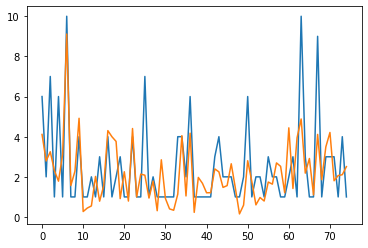

In [289]:
plt.plot(pf.CANTIDAD)
plt.plot(pf.predic)

In [67]:
y_test

745    1
746    2
747    1
748    4
749    1
      ..
819    2
820    1
821    1
822    2
823    3
Name: CANTIDAD, Length: 79, dtype: int64

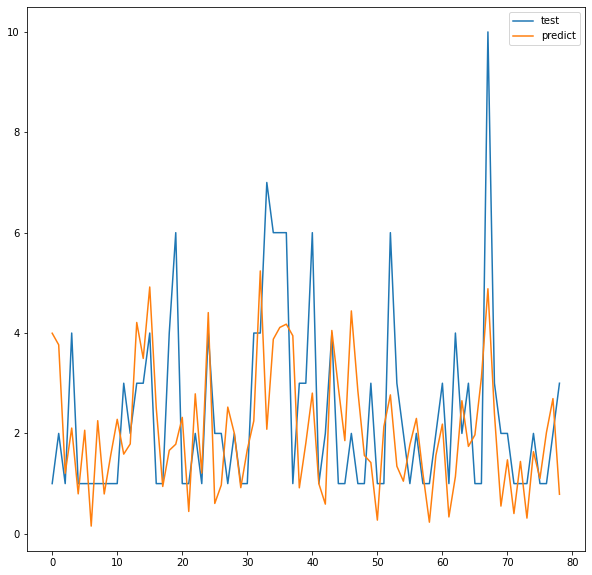

In [70]:
plt.figure(figsize=(10,10))
plt.plot(range(len(res.predict(sm.add_constant(X_test, has_constant='add')))),y_test,label='test')
plt.plot(range(len(res.predict(sm.add_constant(X_test, has_constant='add')))),res.predict(sm.add_constant(X_test, has_constant='add')),label='predict')
plt.legend()

In [90]:
br=GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 40})

br.fit(X_train,y_train)


GradientBoostingRegressor(max_depth=7, n_estimators=40)

In [94]:
mse(y_test,br.predict(X_test))

2.2688266683860565

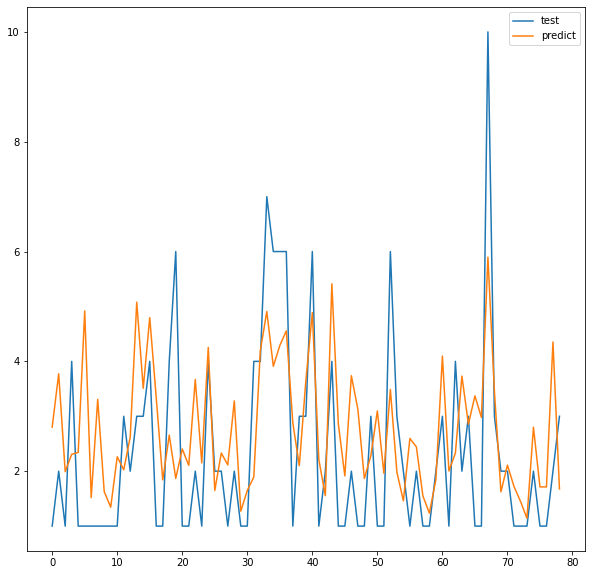

In [92]:

plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),br.predict(X_test),label='predict')
plt.legend()

In [93]:
param_dist = {'n_estimators':[30, 40, 100, 200, 300],'learning_rate':[0.01, 0.05, 0.1, 0.3, 0.4, 1], 'max_depth': [2,4,6,8,10]}

grid_br_mae = GridSearchCV(GradientBoostingRegressor(), param_grid = param_dist,cv=3,n_jobs=4,scoring='neg_mean_absolute_error')
grid_br_mae.fit(X_train, y_train)



GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.4, 1],
                         'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [30, 40, 100, 200, 300]},
             scoring='neg_mean_absolute_error')

In [95]:
grid_br_mae.best_score_

-1.69432194373168

In [96]:
grid_br_mae.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 30}

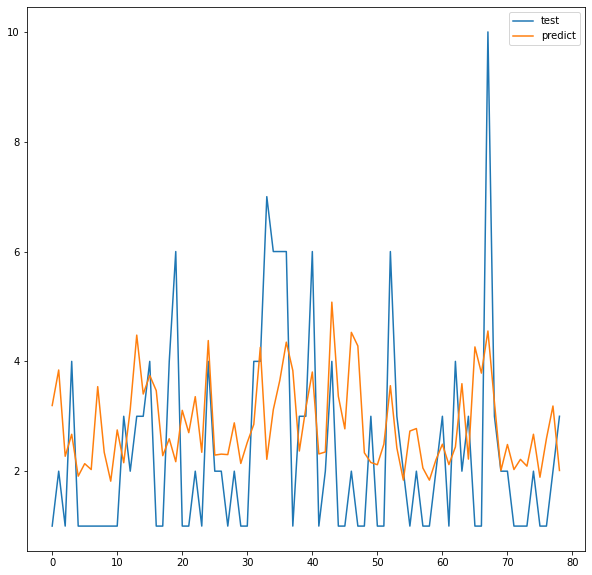

In [97]:

plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),grid_br_mae.predict(X_test),label='predict')
plt.legend()

In [99]:
grid_br_mape = GridSearchCV(GradientBoostingRegressor(), param_grid = param_dist,cv=3,n_jobs=4,scoring='neg_mean_absolute_percentage_error')
grid_br_mape.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.4, 1],
                         'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [30, 40, 100, 200, 300]},
             scoring='neg_mean_absolute_percentage_error')

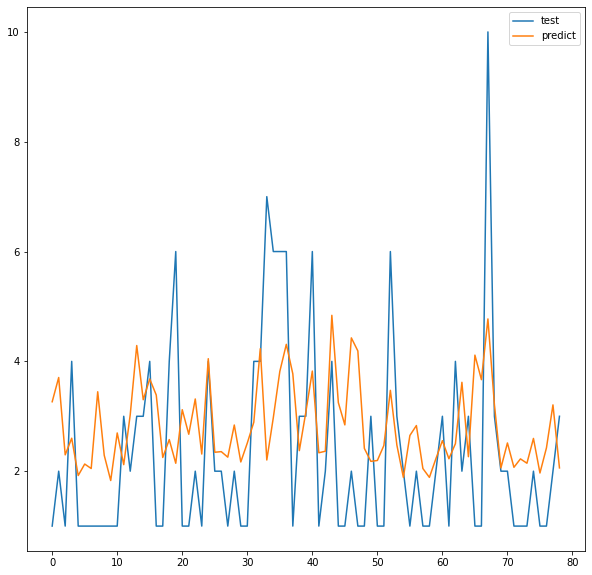

In [100]:

plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),grid_br_mape.predict(X_test),label='predict')
plt.legend()

In [102]:
from sklearn.metrics import mean_absolute_percentage_error as mape
mape(grid_br_mape.predict(X_test),y_test)

0.4950633495704558

Una forma mas general por caracteristicas

In [267]:
sales_cat=sales_ref_month2.groupby(['ANIO','MES','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','MATERIAL_POS','ESTILO','ACABADO','PUESTOS','VIGENCIA','ORIGEN']).agg({'PRECIO':'mean','SUBTOTAL':'sum','DESCUENTO(%)':'mean','TOTAL':'sum','CANTIDAD':'sum','ALTO':'mean','AREA':'mean','Factor covid':'first'}).reset_index()

In [272]:

sales_cat

,ANIO,MES,COLOR_POS,CATEGORIA,SUBCATEGORIA_POS,MATERIAL_POS,ESTILO,ACABADO,PUESTOS,VIGENCIA,ORIGEN,PRECIO,SUBTOTAL,DESCUENTO(%),TOTAL,CANTIDAD,ALTO,AREA,Factor covid
0,2019,1,AMARILLO,COMEDORES,SET 4P,VIDRIO,CONTEMPORÁNEO,BRILLANTE,4.0,DESCONTINUADO,IMPORTADO,1.031024e+06,1031024,0.600000,412410,1,75.0,10000.0,0
1,2019,1,AMARILLO,COMEDORES,SILLAS DE COMEDOR,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,1.0,NOVEDAD,IMPORTADO,2.462980e+05,246298,0.000000,246298,1,77.0,1880.0,0
2,2019,1,AMARILLO,SALAS Y SOFAS,SILLAS AUXILIARES,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,1.0,LINEA,IMPORTADO,1.902940e+05,190294,0.599998,76118,1,78.0,2200.0,0
3,2019,1,AZUL,COMEDORES,OTROS,MICROFIBRA,MODERNO,TEXTILES SUAVES,1.0,DESCONTINUADO,IMPORTADO,2.469570e+05,493914,0.175000,407479,2,100.0,3000.0,0
4,2019,1,AZUL,SALAS Y SOFAS,MESAS DE CENTRO,VIDRIO,CONTEMPORÁNEO,BRILLANTE,0.0,DESCONTINUADO,IMPORTADO,5.460780e+05,546078,0.500000,273039,1,50.0,7200.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6557,2021,4,OTRO,SALAS Y SOFAS,SOFA CAMA ABATIBLE,MICROFIBRA,MODERNO,TEXTILES SUAVES,3.0,LINEA,MANUFACTURADO,6.610620e+05,661062,0.543489,301782,1,82.0,16744.0,1
6558,2021,4,ROJO,SALAS Y SOFAS,POLTRONAS,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,1.0,NOVEDAD,IMPORTADO,6.157650e+05,615765,0.390907,375058,1,80.0,3819.0,1
6559,2021,4,ROJO,SALAS Y SOFAS,POLTRONAS,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,1.0,NOVEDAD,NACIONAL,5.626908e+05,6152812,0.515910,3173041,11,77.0,4104.0,1
6560,2021,4,ROJO,SALAS Y SOFAS,SOFA 2P,OTRO,CONTEMPORÁNEO,TEXTILES SUAVES,2.0,NOVEDAD,MANUFACTURADO,1.349659e+06,8097952,0.546970,3665683,6,77.0,13833.0,1


In [372]:
num_var=['AREA','ALTO','DESCUENTO(%)','PRECIO','CANTIDAD',]
cat_var=['MES','Factor covid','PUESTOS','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','VIGENCIA','ORIGEN','ESTILO','MATERIAL_POS','ACABADO']

y=sales_cat['CANTIDAD']

X_num=sales_cat[num_var[:-1]].astype('float')
X_cat=sales_cat[cat_var].astype('category')

X_cat_dummies=pd.get_dummies(X_cat)

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
X_num_norm= scaler.fit_transform(X_num)


X=np.append(X_num_norm,X_cat_dummies,axis=1)

#split data till januar 2021
index=sales_cat[(sales_cat.ANIO==2021)].index[0]
X_train=X[:index-1]
y_train=y[:index-1]
X_test=X[index:]
y_test=y[index:]


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse

mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
res.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               CANTIDAD   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     13.24
Date:                Sat, 28 Aug 2021   Prob (F-statistic):          9.28e-137
Time:                        07:11:26   Log-Likelihood:                -15281.
No. Observations:                5579   AIC:                         3.070e+04
Df Residuals:                    5508   BIC:                         3.118e+04
Df Model:                          70                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -4.809e+12   4.54e+12     -1.059      0.290   -1.37e+13    4.09e+12
x1            -0.8811      0.847     -1.040      0.298      -2.541       0.779
x2             0.5389      0.688      0.783      0.434      -0.810       1.888
x3             0.7723      0.319      2.421      0.016       0.147       1.398
x4            -4.4919      0.818     -5.491      0.000      -6.096      -2.888
x5         -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x6         -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x7         -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x8         -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x9         -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x10        -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x11        -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x12        -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x13        -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x14        -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x15        -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x16        -4.758e+11   4.49e+11     -1.059      0.290   -1.36e+12    4.05e+11
x17         6.838e+12   6.46e+12      1.059      0.290   -5.82e+12    1.95e+13
x18         6.838e+12   6.46e+12      1.059      0.290   -5.82e+12    1.95e+13
x19         6.838e+12   6.46e+12      1.059      0.290   -5.82e+12    1.95e+13
x20         6.838e+12   6.46e+12      1.059      0.290   -5.82e+12    1.95e+13
x21         -8.37e+11    7.9e+11     -1.059      0.290   -2.39e+12    7.12e+11
x22         -8.37e+11    7.9e+11     -1.059      0.290   -2.39e+12    7.12e+11
x23         -8.37e+11    7.9e+11     -1.059      0.290   -2.39e+12    7.12e+11
x24         -8.37e+11    7.9e+11     -1.059      0.290   -2.39e+12    7.12e+11
x25         -8.37e+11    7.9e+11     -1.059      0.290   -2.39e+12    7.12e+11
x26         -8.37e+11    7.9e+11     -1.059      0.290   -2.39e+12    7.12e+11
x27         -8.37e+11    7.9e+11     -1.059      0.290   -2.39e+12    7.12e+11
x28        -4.872e+11    4.6e+11     -1.059      0.290   -1.39e+12    4.15e+11
x29        -4.872e+11    4.6e+11     -1.059      0.290   -1.39e+12    4.15e+11
x30        -4.872e+11    4.6e+11     -1.059      0.290   -1.39e+12    4.15e+11
x31        -4.872e+11    4.6e+11     -1.059      0.290   -1.39e+12    4.15e+11
x32        -4.872e+11    4.6e+11     -1.059      0.290   -1.39e+12    4.15e+11
x33        -4.872e+11    4.6e+11     -1.059      0.290   -1.39e+12    4.15e+11
x34        -4.872e+11    4.6e+11     -1.059      0.290   -1.39e+12    4.15e+11
x35        -4.872e+11    4.6e+11     -1.059      0.290   -1.39e+12    4.15e+11
x3

In [373]:
X_test

y_predicted=res.predict(sm.add_constant(X_test))
mse(y_test,y_predicted)


13.703832067169872

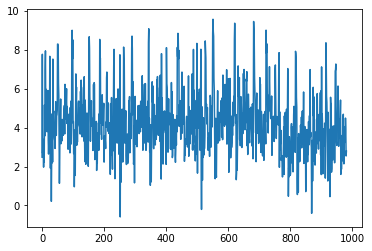

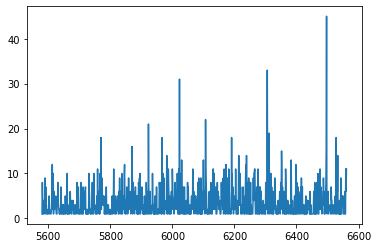

In [374]:
plt.figure()
plt.plot(y_predicted)
plt.figure()
plt.plot(y_test)

In [375]:
br=GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 40})

br.fit(X_train,y_train)

br.predict(X_test)


array([ 3.74576948,  7.91843989,  4.5558589 ,  4.9927233 ,  5.32255171,
        4.75562939,  3.34276241,  2.44499006,  4.95008722,  5.28424512,
        5.19731763,  6.10013334,  5.26558653,  5.58431323,  5.57178416,
        6.01019344,  4.79264108,  2.91072678,  5.06156473,  5.06728511,
        2.32833471,  2.68688212,  5.26190433,  5.14401388,  4.82439039,
        5.65582261,  5.73971807,  4.83342701,  5.60476713,  3.45425807,
        3.97532311,  4.17707979,  6.4141638 ,  6.42604757,  4.63061821,
        8.11492751,  7.65363653,  5.21248584,  3.7187472 ,  4.98559352,
        4.68743578,  4.47424363,  4.47424363,  4.91471134,  6.07196887,
        5.24050925,  4.78103366,  4.88346135,  2.99635793,  5.2899655 ,
        7.42139028,  8.56519262, 11.10753367,  5.24703223,  5.31488016,
        5.05250596,  2.62355159,  5.47980164,  3.19177002,  3.07825424,
        5.1718073 ,  5.15981396,  6.2648574 ,  4.14359327,  4.27496616,
        4.50417891,  4.6978713 ,  4.27496616,  3.50761586,  4.67

In [376]:
mse(y_test,br.predict(X_test))

12.254819270042018

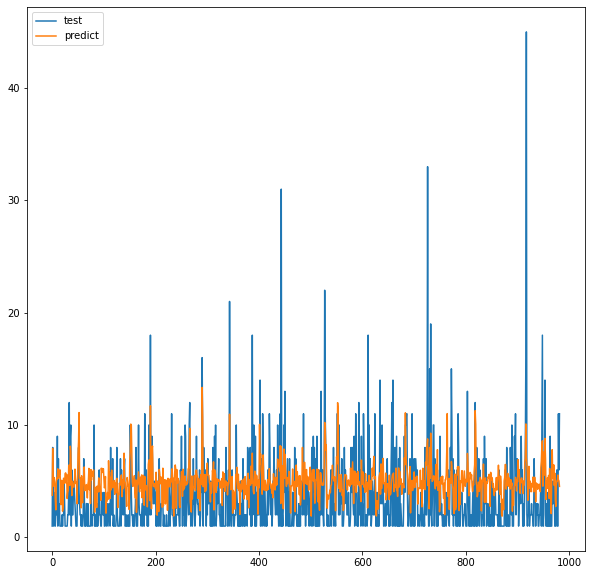

In [377]:
plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),br.predict(X_test),label='predict')
plt.legend()

12.660043425172173

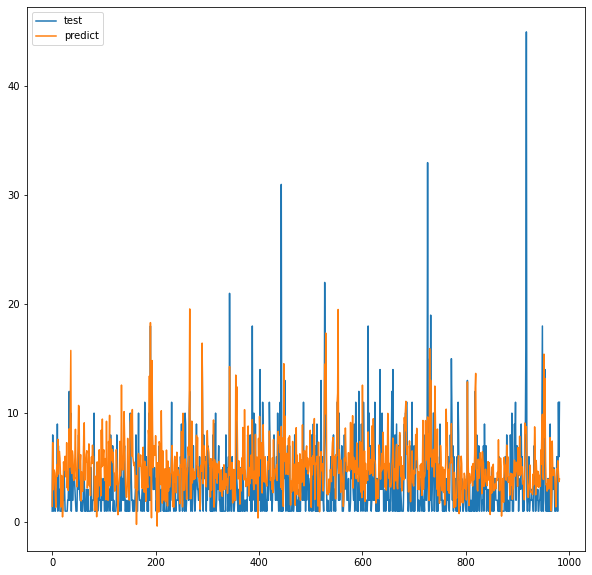

In [378]:
grid_br_mse = GridSearchCV(GradientBoostingRegressor(), param_grid = param_dist,cv=3,n_jobs=4,scoring='neg_mean_squared_error')
grid_br_mse.fit(X_train, y_train)


plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),grid_br_mse.predict(X_test),label='predict')
plt.legend()

mse(grid_br_mse.predict(X_test),y_test)

ahora con lag

In [304]:
sales_cat_lag=sales_cat.copy()


In [305]:
for i in range(12):
    sales_cat_lag['CANTIDAD_{}'.format(i+1)]=sales_cat.groupby(['COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','MATERIAL_POS','ESTILO','ACABADO'])[['CANTIDAD']].shift(i+1)

In [306]:
sales_cat_lag=sales_cat_lag.dropna()
sales_cat_lag=sales_cat_lag.reset_index(drop=True)


<AxesSubplot:>

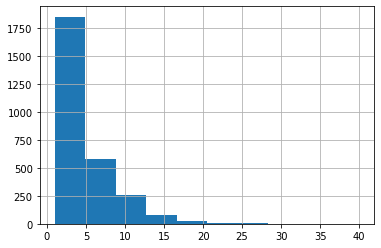

In [307]:
sales_cat_lag['CANTIDAD'].hist()

In [257]:
sales_cat_lag[sales_cat_lag['CANTIDAD']>45]['SUBCATEGORIA_POS'].value_counts()

Series([], Name: SUBCATEGORIA_POS, dtype: int64)

In [280]:
sales_cat_lag.head(5)

,ANIO,MES,COLOR_POS,CATEGORIA,SUBCATEGORIA_POS,MATERIAL_POS,ESTILO,ACABADO,PUESTOS,VIGENCIA,ORIGEN,PRECIO,SUBTOTAL,DESCUENTO(%),TOTAL,CANTIDAD,ALTO,AREA,Factor covid,CANTIDAD_1,CANTIDAD_2,CANTIDAD_3,CANTIDAD_4,CANTIDAD_5,CANTIDAD_6,CANTIDAD_7,CANTIDAD_8,CANTIDAD_9,CANTIDAD_10,CANTIDAD_11,CANTIDAD_12
0,2019,3,NEGRO,COMEDORES,OTROS,VIDRIO,MODERNO,BRILLANTE,4.0,LINEA,IMPORTADO,446685.0,1340055,0.550001,603024,3,120.0,3500.0,0,10.0,9.0,1.0,1.0,1.0,2.0,5.0,15.0,2.0,1.0,2.0,4.0
1,2019,3,NEGRO,COMEDORES,OTROS,VIDRIO,MODERNO,BRILLANTE,6.0,DESCONTINUADO,IMPORTADO,582278.0,5822780,0.470001,3086066,10,75.0,17000.0,0,3.0,10.0,9.0,1.0,1.0,1.0,2.0,5.0,15.0,2.0,1.0,2.0
2,2019,3,NEGRO,COMEDORES,OTROS,VIDRIO,MODERNO,BRILLANTE,6.0,LINEA,IMPORTADO,890858.0,890858,0.500000,445429,1,76.0,11600.0,0,10.0,3.0,10.0,9.0,1.0,1.0,1.0,2.0,5.0,15.0,2.0,1.0
3,2019,4,NEGRO,COMEDORES,OTROS,VIDRIO,MODERNO,BRILLANTE,0.0,DESCONTINUADO,IMPORTADO,621486.0,1242972,0.350000,807932,2,79.0,6000.0,0,1.0,10.0,3.0,10.0,9.0,1.0,1.0,1.0,2.0,5.0,15.0,2.0
4,2019,4,NEGRO,COMEDORES,OTROS,VIDRIO,MODERNO,BRILLANTE,0.0,LINEA,IMPORTADO,320000.0,1920000,0.750000,480000,6,80.0,2400.0,0,2.0,1.0,10.0,3.0,10.0,9.0,1.0,1.0,1.0,2.0,5.0,15.0


<AxesSubplot:>

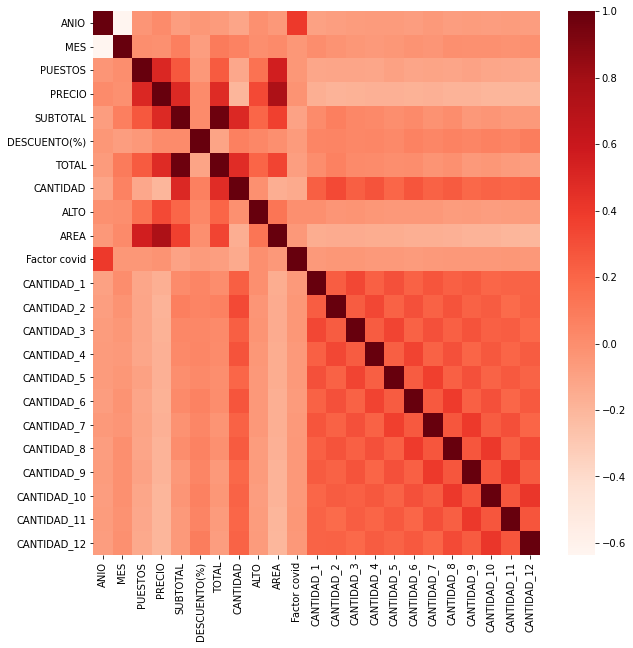

In [117]:
plt.figure(figsize=(10,10))
sns.heatmap(sales_cat_lag.corr(),cmap='Reds')

In [359]:
num_var=['AREA','ALTO','DESCUENTO(%)','PRECIO']
for i in range(1,13):
    num_var.append('CANTIDAD_{}'.format(i))
num_var.append('CANTIDAD')
cat_var=['MES','Factor covid','PUESTOS','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','VIGENCIA','ORIGEN','ESTILO','MATERIAL_POS','ACABADO']

y=sales_cat_lag['CANTIDAD']

X_num=sales_cat_lag[num_var[:-1]].astype('float')
X_cat=sales_cat_lag[cat_var].astype('category')

X_cat_dummies=pd.get_dummies(X_cat)

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
X_num_norm= scaler.fit_transform(X_num)


X=np.append(X_num_norm,X_cat_dummies,axis=1)

#split data till month 4 from 2021
index=sales_cat_lag[(sales_cat_lag.ANIO==2021) & (sales_cat_lag.MES==1)].head(1).index.values[0]
X_train=X[:index-1]
y_train=(y[:index-1])
X_test=X[index:]
y_test=(y[index:])


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse

mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
res.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               CANTIDAD   R-squared:                       0.272
Model:                            OLS   Adj. R-squared:                  0.244
Method:                 Least Squares   F-statistic:                     9.739
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           1.97e-92
Time:                        06:56:10   Log-Likelihood:                -5721.0
No. Observations:                2109   AIC:                         1.160e+04
Df Residuals:                    2030   BIC:                         1.205e+04
Df Model:                          78                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.2263      0.390      3.144      0.002       0.461       1.991
x1            -0.8574      1.329     -0.645      0.519      -3.463       1.748
x2            -0.5292      1.268     -0.417      0.676      -3.016       1.957
x3             0.3470      0.547      0.634      0.526      -0.726       1.420
x4            -4.2701      1.265     -3.375      0.001      -6.752      -1.789
x5             1.0185      0.841      1.211      0.226      -0.631       2.668
x6             7.0699      0.830      8.521      0.000       5.443       8.697
x7             2.4312      0.850      2.861      0.004       0.765       4.098
x8             3.6753      0.843      4.361      0.000       2.022       5.328
x9            -0.6770      0.851     -0.796      0.426      -2.345       0.991
x10            0.5700      0.837      0.681      0.496      -1.072       2.212
x11            0.5604      0.840      0.667      0.505      -1.087       2.207
x12            2.0567      0.842      2.443      0.015       0.406       3.708
x13           -0.4862      0.833     -0.584      0.560      -2.120       1.148
x14            0.1453      0.845      0.172      0.863      -1.511       1.802
x15            1.9150      0.821      2.332      0.020       0.305       3.525
x16            0.7810      0.819      0.953      0.341      -0.826       2.388
x17            0.4123      0.418      0.987      0.324      -0.407       1.231
x18            1.0885      0.412      2.643      0.008       0.281       1.896
x19            0.3276      1.207      0.271      0.786      -2.040       2.695
x20           -1.3418      1.162     -1.155      0.248      -3.620       0.936
x21           -1.1199      0.554     -2.023      0.043      -2.206      -0.034
x22           -0.2751      0.410     -0.671      0.502      -1.079       0.529
x23            0.1509      0.384      0.393      0.694      -0.602       0.903
x24           -0.1847      0.391     -0.473      0.637      -0.951       0.582
x25            0.2006      0.386      0.520      0.603      -0.557       0.958
x26            0.4642      0.342      1.357      0.175      -0.206       1.135
x27            0.6195      0.335      1.849      0.065      -0.038       1.277
x28            0.8841      0.362      2.444      0.015       0.175       1.593
x29            0.9335      0.381      2.450      0.014       0.186       1.681
x30            0.5387      0.420      1.283      0.200      -0.285       1.362
x31            0.2186      0.428      0.511      0.609      -0.620       1.058
x32           -0.4645      1.079     -0.431      0.667      -2.581       1.651
x33           -1.0179      0.592     -1.720      0.086      -2.179       0.143
x34           -2.3967      1.173     -2.043      0.041      -4.697      -0.096
x35            1.4112      0.477      2.961      0.003       0.476       2.346
x3

In [360]:

y_predicted=res.predict(sm.add_constant(X_test, has_constant='add'))
mse(y_test,y_predicted)


12.155746092782884

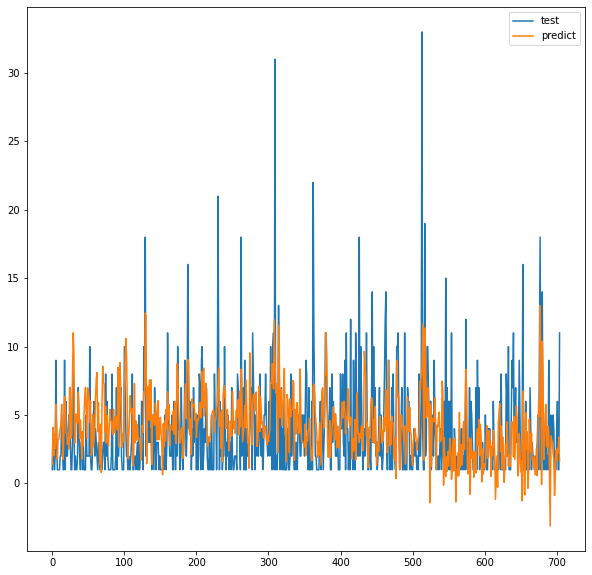

In [361]:
plt.figure(figsize=(10,10))
plt.plot(range(len(res.predict(sm.add_constant(X_test, has_constant='add')))),y_test,label='test')
plt.plot(range(len(res.predict(sm.add_constant(X_test, has_constant='add')))),res.predict(sm.add_constant(X_test, has_constant='add')),label='predict')
plt.legend()

In [362]:
br=GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 80})

br.fit(X_train,y_train)



GradientBoostingRegressor(max_depth=6, n_estimators=80)

In [363]:
mse(y_test,br.predict(X_test))

11.79380502465334

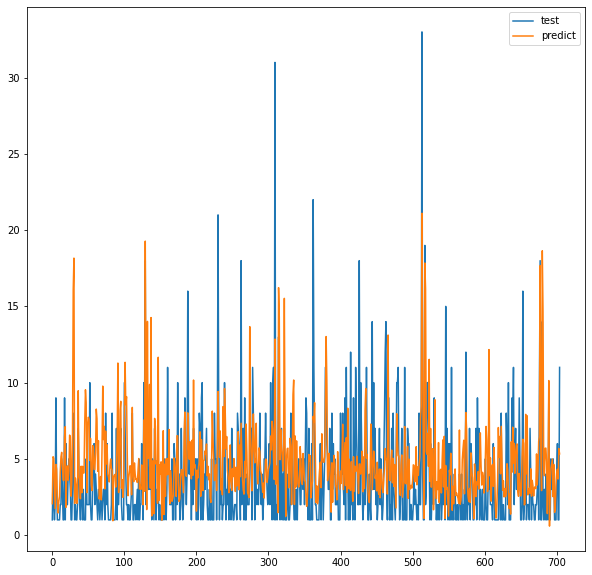

In [364]:
plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),br.predict(X_test),label='predict')
plt.legend()

In [365]:
br.predict(X_test).sum()

3344.130082445761

In [366]:
y_test.sum()

2638

In [367]:
r2(br.predict(X_test),y_test)

-0.707759983612757

In [368]:
grid_br_mape = GridSearchCV(GradientBoostingRegressor(), param_grid = param_dist,cv=3,n_jobs=4,scoring='neg_mean_absolute_percentage_error')
grid_br_mape.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.4, 1],
                         'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [30, 40, 100, 200, 300]},
             scoring='neg_mean_absolute_percentage_error')

0.5548367897662179

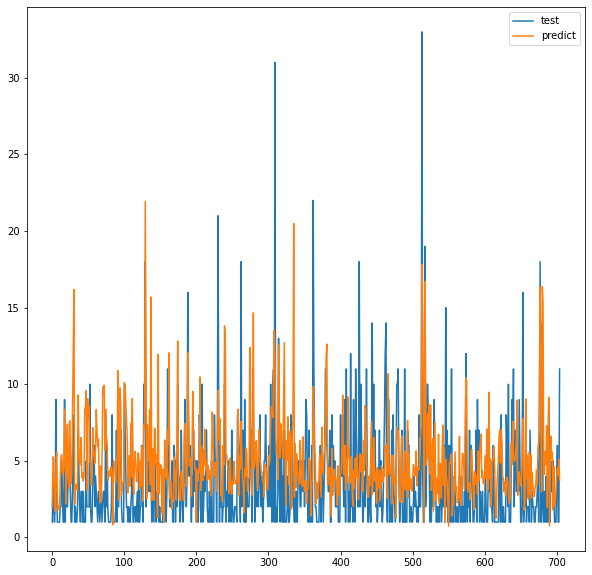

In [369]:

plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),grid_br_mape.predict(X_test),label='predict')
plt.legend()

mape(grid_br_mape.predict(X_test),y_test)

In [370]:
grid_br_mse = GridSearchCV(GradientBoostingRegressor(), param_grid = param_dist,cv=3,n_jobs=4,scoring='neg_mean_squared_error')
grid_br_mse.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.4, 1],
                         'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [30, 40, 100, 200, 300]},
             scoring='neg_mean_squared_error')

11.810640818082982

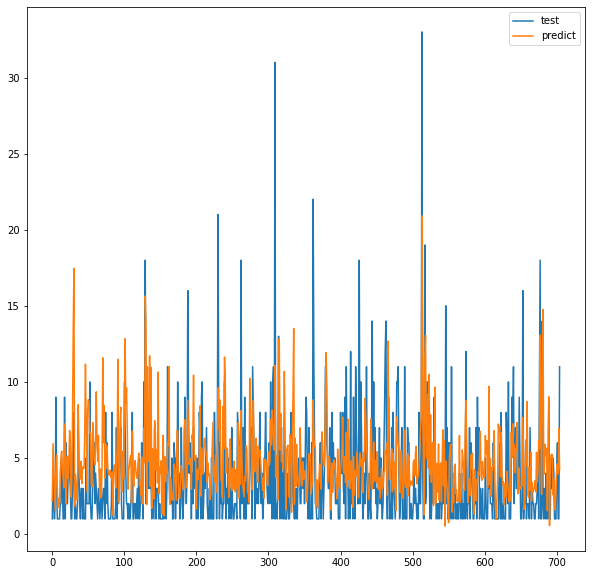

In [371]:

plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),grid_br_mse.predict(X_test),label='predict')
plt.legend()

mse(grid_br_mse.predict(X_test),y_test)

una prueba final

In [356]:
sales_ref_month2=sales_ref_month.loc[remove_outlier_IQR(sales_ref_month['CANTIDAD']).index].reset_index(drop=True)

num_var=['AREA','ALTO','DESCUENTO(%)','PRECIO','CANTIDAD',]
cat_var=['MES','Factor covid','PUESTOS','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','VIGENCIA','ORIGEN','ESTILO','MATERIAL_POS','ACABADO']

y=sales_ref_month2['CANTIDAD']

X_num=sales_ref_month2[num_var[:-1]].astype('float')
X_cat=sales_ref_month2[cat_var].astype('category')

X_cat_dummies=pd.get_dummies(X_cat)

from sklearn.preprocessing import MinMaxScaler, StandardScaler

scaler=MinMaxScaler()
X_num_norm= scaler.fit_transform(X_num)


X=np.append(X_num_norm,X_cat_dummies,axis=1)

#split data till januar 2021
index=sales_ref_month2[(sales_ref_month2.ANIO==2021)].index[0]
X_train=X[:index-1]
y_train=y[:index-1]
X_test=X[index:]
y_test=y[index:]


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse

mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
res.summary()

y_predicted=res.predict(sm.add_constant(X_test,has_constant='add'))
mse(y_test,y_predicted)

5.340087460794836

In [357]:
test=sales_ref_month2.loc[index:]
test['predicted']=y_predicted
pf=test.groupby(['ANIO','MES','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','MATERIAL_POS','ESTILO','ACABADO','PUESTOS','VIGENCIA','ORIGEN']).agg({'CANTIDAD':'sum','predicted':'sum'}).reset_index()

In [358]:
mse(pf.CANTIDAD,pf.predicted)

8.0090090467245

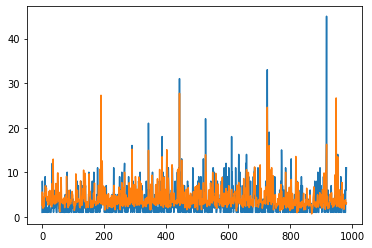

In [355]:
plt.plot(pf.CANTIDAD)
plt.plot(pf.predicted)

In [351]:
sales_cat=sales_ref_month2.groupby(['ANIO','MES','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','MATERIAL_POS','ESTILO','ACABADO','PUESTOS','VIGENCIA','ORIGEN']).agg({'PRECIO':'mean','SUBTOTAL':'sum','DESCUENTO(%)':'mean','TOTAL':'sum','CANTIDAD':'sum','ALTO':'mean','AREA':'mean','Factor covid':'first'}).reset_index()


num_var=['AREA','ALTO','DESCUENTO(%)','PRECIO','CANTIDAD',]
cat_var=['MES','Factor covid','PUESTOS','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','VIGENCIA','ORIGEN','ESTILO','MATERIAL_POS','ACABADO']

y=sales_cat['CANTIDAD']

X_num=sales_cat[num_var[:-1]].astype('float')
X_cat=sales_cat[cat_var].astype('category')

X_cat_dummies=pd.get_dummies(X_cat)

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
X_num_norm= scaler.fit_transform(X_num)


X=np.append(X_num_norm,X_cat_dummies,axis=1)

#split data till januar 2021
index=sales_cat[(sales_cat.ANIO==2021)].index[0]
X_train=X[:index-1]
y_train=y[:index-1]
X_test=X[index:]
y_test=y[index:]


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse

mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
res.summary()




X_test

y_predicted=res.predict(sm.add_constant(X_test))
mse(y_test,y_predicted)


13.703832067169872

In [ ]:
plt.plot(pf.CANTIDAD)
plt.plot(pf.predicted)

In [352]:
sales_cat[index:]==

,ANIO,MES,COLOR_POS,CATEGORIA,SUBCATEGORIA_POS,MATERIAL_POS,ESTILO,ACABADO,PUESTOS,VIGENCIA,ORIGEN,PRECIO,SUBTOTAL,DESCUENTO(%),TOTAL,CANTIDAD,ALTO,AREA,Factor covid
5580,2021,1,AMARILLO,COMEDORES,SET 4P,VIDRIO,CONTEMPORÁNEO,BRILLANTE,4.0,DESCONTINUADO,IMPORTADO,1.113506e+06,1113506,0.550000,501078,1,75.0,10000.0,2
5581,2021,1,AMARILLO,COMEDORES,SILLAS DE COMEDOR,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,1.0,NOVEDAD,IMPORTADO,2.685821e+05,2153255,0.519563,1007866,8,77.0,1880.0,2
5582,2021,1,AMARILLO,SALAS Y SOFAS,PUFF,MICROFIBRA,MODERNO,TEXTILES SUAVES,1.0,LINEA,MANUFACTURADO,1.331097e+05,532438,0.666669,166386,4,46.0,1296.0,2
5583,2021,1,AMARILLO,SALAS Y SOFAS,SILLAS AUXILIARES,OTRO,CONTEMPORÁNEO,TEXTURA SUAVE,1.0,DESCONTINUADO,IMPORTADO,2.395740e+05,239574,0.599998,95830,1,83.0,2565.0,2
5584,2021,1,AMARILLO,SALAS Y SOFAS,SOFA 2P,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,2.0,DESCONTINUADO,MANUFACTURADO,1.222855e+06,4891420,0.532578,2282823,4,85.0,11815.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6557,2021,4,OTRO,SALAS Y SOFAS,SOFA CAMA ABATIBLE,MICROFIBRA,MODERNO,TEXTILES SUAVES,3.0,LINEA,MANUFACTURADO,6.610620e+05,661062,0.543489,301782,1,82.0,16744.0,1
6558,2021,4,ROJO,SALAS Y SOFAS,POLTRONAS,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,1.0,NOVEDAD,IMPORTADO,6.157650e+05,615765,0.390907,375058,1,80.0,3819.0,1
6559,2021,4,ROJO,SALAS Y SOFAS,POLTRONAS,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,1.0,NOVEDAD,NACIONAL,5.626908e+05,6152812,0.515910,3173041,11,77.0,4104.0,1
6560,2021,4,ROJO,SALAS Y SOFAS,SOFA 2P,OTRO,CONTEMPORÁNEO,TEXTILES SUAVES,2.0,NOVEDAD,MANUFACTURADO,1.349659e+06,8097952,0.546970,3665683,6,77.0,13833.0,1
